# **Try Model**

This notebook allows users to test a pretrained PAW model for predicting amplitude windows in seismic datasets. 

In [1]:
# Install necessary packages (if not installed)
# !pip install pytorch-lightning torch h5py matplotlib

# Import necessary libraries
import os
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from src.model import PAW, PLWrapper
from src.utils import preprocess
from src.utils import AmpPerLoss
from src.dataloader import SeismicDataset

# Set global configurations
print("Notebook Initialized. Ensure all dependencies are satisfied.")

Notebook Initialized. Ensure all dependencies are satisfied.


### **Step 1: Define Hyperparameters and Arguments**

In [2]:
# Configure model and dataset parameters
data_folder = "."  # Path to dataset folder
data_name = "dataset"  # Name of the H5 dataset file
model_id = 1  # Unique model ID
padding = 0.5  # Padding for the observed window
label_type = 'binary'  # Label type ('binary', 'gaussian', 'orig')
model_name = 'paw'  # Model name
loss_type = 'bce'  # Loss function ('mse', 'bce', 'amper')

# Training configurations
freq = 0.025
batch_size = 32
learning_rate = 1e-3
scale_type = 'MinMax'
metric = 'pdf'

# Configure loss function
if loss_type == 'bce':
    loss_fn = torch.nn.BCELoss()
elif loss_type == 'mse':
    loss_fn = torch.nn.MSELoss()
elif loss_type == 'amper':
    loss_fn = AmpPerLoss()

print("Hyperparameters defined.")

Hyperparameters defined.


### **Step 2: Load Dataset**

In [3]:
# Load seismic data
dir_name = os.path.dirname(os.path.abspath('__file__'))

with h5py.File(os.path.join(dir_name, f'{data_folder}/{data_name}.h5'), "r") as f:
    data = f['waveforms'][()]
    labels = f['labels'][()]

# Add padding to data
data = np.concatenate([
    np.zeros((data.shape[0], round((padding)/freq), 1)),
    data,
    np.zeros((data.shape[0], round((padding)/freq), 1))
], axis=1)

print(f"Loaded data shape: {data.shape}")

Loaded data shape: (80648, 240, 1)


### **Step 3: Configure and Load the Model**

In [4]:
# Define model configuration
config = {
    'padding': padding,
    'metric': metric,
    'transformation': scale_type,
    'shape': data.shape,
    'out_shape': data.shape[-1],
    'lr': learning_rate
}

# Initialize the model
model_base = PAW(config)
model = PLWrapper(None, config, model_base, loss_fn, model_base.__class__)

# Load pretrained model checkpoint
trial_name = f'wdif_{model_name}_{model_id}_{loss_fn.__class__.__name__}'

try:
    checkpoint = torch.load(f'models/{trial_name}.pth')
    model.load_state_dict(checkpoint)
    print("Model checkpoint loaded successfully.")
except Exception as e:
    print(f"Error loading model checkpoint: {e}")

Model checkpoint loaded successfully.


### **Step 4: Preprocess Data**

In [5]:
# Preprocess data and labels
t = np.arange(0, 5 + freq, freq)
pre_data, pre_labels = preprocess(data, labels, metric, t, freq, scale_type, padding, label_type)

# Convert data to float32
pre_data = pre_data.astype(np.float32)
pre_labels = pre_labels.astype(np.float32)

print(f"Preprocessed data shape: {pre_data.shape}")

Preprocessed data shape: (80648, 240, 1)


### **Step 5: Test the Model**

In [6]:
# Select a single sample for testing
sample_idx = 0  # Index of the sample to test
sample_data = pre_data[sample_idx:sample_idx+2]
sample_label = pre_labels[sample_idx:sample_idx+2]

# Create DataLoader for a single sample
dataset = SeismicDataset(sample_data, sample_label)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    devices='auto',
    accelerator='auto',
    benchmark=True,
    log_every_n_steps=10,
    enable_progress_bar=True
)

# Test the model on the single sample
start_time_test = time.time()
preds = trainer.predict(model, loader)[0]
end_time_test = time.time()

# Calculate forward time
forward_time = (end_time_test - start_time_test) / len(loader.dataset)
print(f"Forward time for the sample: {forward_time:.6f} seconds")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ariana/miniforge3/envs/paw/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Forward time for the sample: 0.364123 seconds


### **Step 6: Visualize Results**

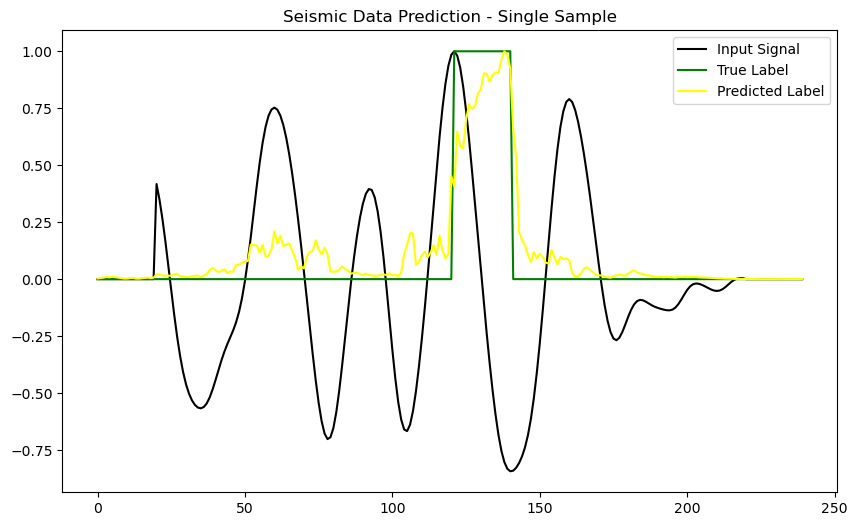

In [7]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(preds['x'][0].squeeze(), c='black', label='Input Signal')
plt.plot(preds['y'][0].squeeze(), c='green', label='True Label')
plt.plot(preds['y_hat'][0].squeeze(), c='yellow', label='Predicted Label')
plt.title("Seismic Data Prediction - Single Sample")
plt.legend()
plt.show()